# Venkatesh Prasad Venkataramanan PID : A53318036

In [52]:
%matplotlib inline

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Question 1

In [16]:
dataset_root_dir = '/datasets/ee285f-public/caltech_ucsd_birds'

## Question 2

In [17]:
class BirdsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
               format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            # COMPLETE
            ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d

    def number_of_classes(self):
        return self.data['class'].max() + 1

## Question 3

In [18]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h


In [51]:
train_set = BirdsDataset(dataset_root_dir)
x = train_set.__getitem__(10)

0


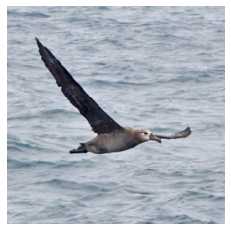

In [53]:
plt.figure()
myimshow(x[0])
print (x[1])

Hence , we can see that the label for this is 0.

## Question 4

In [21]:
train_loader = td.DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

In [22]:
len(train_loader)

47

So number of minibatches is 47.

The data loader will copy tensors into CUDA pinned memory before returning them. This lets the DataLoader allocate the samples in page-locked memory, which speeds-up the transfer. This is the advantage of using pin memory.

## Question 5

tensor(9)
tensor(16)
tensor(5)
tensor(12)


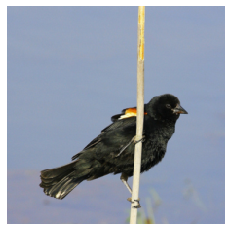

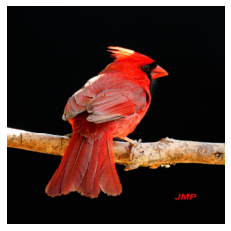

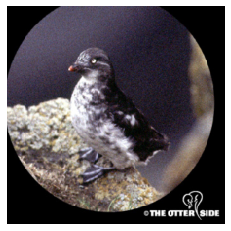

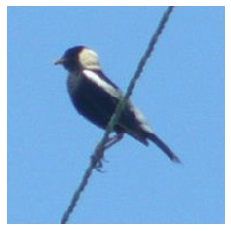

In [54]:
for batch_idx, batch in enumerate(train_loader):
    if batch_idx == 4:
        break
        
    plt.figure()
    myimshow(batch[0][0])
    print (batch[1][0])

Here, I am displaying images of first four minibatches and their labels. Since I am using shuffle = True, I will get different images every time I run this.

## Question 6

In [24]:
val_set = BirdsDataset(dataset_root_dir, mode='val')
val_loader = td.DataLoader(val_set, batch_size=16, pin_memory=True)

By default, shuffle is set to false. During validation, I don't have to shuffle the dataset because it is used for performance evaluation and hence it will not affect the parameters of the model. But, during training, similar data points might lie close to each other, so we need to shuffle to converge faster.

## Question 7

In [25]:
import nntools as nt

In [26]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

This is because Neural Network is an abstract class in which the functions criterion and forward have not been implemented. On inspecting the nntools.py code, I saw that for both functions, 'pass' has been written. This means that we have to first define them before instantiating them.

In [27]:
class NNClassifier(nt.NeuralNetwork):

    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

## Question 8

In [28]:
vgg = tv.models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:15<00:00, 35.9MB/s] 


In [29]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [30]:
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

vgg command prints the entire network, which has been organised into features, average pool and classifier. Later, we print the learnable parameters, which include weights and biases of features and the classifiers.

## Question 9

In [31]:
class VGG16Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        f = torch.flatten(x, 1)
        y = self.classifier(f)
        return y

After having seen the vgg network, we know that it consists of features, avgpool and classifier. All three have been used to init the network, and also the forward function.

## Question 10

In [32]:
num_classes = train_set.number_of_classes()
print (num_classes)

20


In [33]:
vgg16transfer = VGG16Transfer(num_classes)

In [34]:
vgg16transfer

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [35]:
for name, param in vgg16transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.6.weight torch.Size([20, 4096]) True
classifier.6.bias torch.Size([20]) True


Now, on inspecting the learnable parameters, wee see that only the weight and bias of the final fully connected layer is being learned.

## Question 11

In [36]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}

## Question 12

model.eval() will put all layers in eval mode, and dropout or batchnorm layers will work in eval mode instead of training mode. Since we have batchnorm layers in our VGG16Transfer(), it matters that we switch to eval mode. 

The documentation says that during training, batchnorm layer keeps a running estimate of its computed mean and variance. The running sum is kept with a default momentum of 0.1. On the other hand, during evaluation, this running mean/variance is used for normalization.

Also, by deactivating autograd, we reduce memory usage and speed up the process. We dont need to do backprop in eval.

## Question 13

In [37]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

Config.txt includes structure and hyperparameters of the model, training set and validation set, StatsManager, BatchSize and PerformValidationDuringTraining.

From the documentaion of torch.save(), we can see that checkpoint.pth.tar is dictionary of Net, Optimizer and History, to a disk file, i.e. the file name.

## Question 14

In [38]:
lr = 1e-4
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

While reloading, it will check all the settings of the model in the init() function. Since learning rate is a setting of the model, it will fail to load.

In [39]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

## Question 15

In [40]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    # COMPLETE
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(('training loss', 'evaluation loss'))
    
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                 label="training accuracy")
    # evaluation accuracy
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                 label="evaluation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(('training accuracy', 'evaluation accuracy'), loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()

Start/Continue training from epoch 20
Finish training for 20 epochs


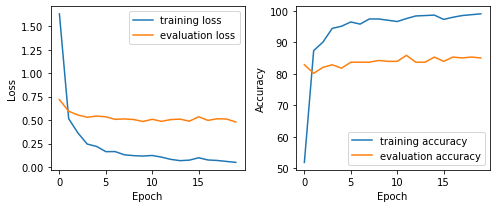

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## Question 16

In [42]:
resnet = tv.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.3MB/s]


In [43]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
for name, param in resnet.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) True
bn1.weight torch.Size([64]) True
bn1.bias torch.Size([64]) True
layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) True
layer1.0.bn1.weight torch.Size([64]) True
layer1.0.bn1.bias torch.Size([64]) True
layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) True
layer1.0.bn2.weight torch.Size([64]) True
layer1.0.bn2.bias torch.Size([64]) True
layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) True
layer1.1.bn1.weight torch.Size([64]) True
layer1.1.bn1.bias torch.Size([64]) True
layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) True
layer1.1.bn2.weight torch.Size([64]) True
layer1.1.bn2.bias torch.Size([64]) True
layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) True
layer2.0.bn1.weight torch.Size([128]) True
layer2.0.bn1.bias torch.Size([128]) True
layer2.0.conv2.weight torch.Size([128, 128, 3, 3]) True
layer2.0.bn2.weight torch.Size([128]) True
layer2.0.bn2.bias torch.Size([128]) True
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1]) True
layer2.

In [45]:
class Resnet18Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        self.classifier = resnet
        num_ftrs = resnet.fc.in_features
        self.classifier.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):     
        y = self.classifier(x)
        return y

In [46]:
resnet18transfer = Resnet18Transfer(num_classes)

In [47]:
resnet18transfer

Resnet18Transfer(
  (cross_entropy): CrossEntropyLoss()
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

In [48]:
# learnable parameters of network
for name, param in resnet18transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.fc.weight torch.Size([20, 512]) True
classifier.fc.bias torch.Size([20]) True


So we can see that the new resnet18 transfer object has redefined the last layer and is only training it.

## Question 17

In [49]:
lr2 = 1e-3
net2 = Resnet18Transfer(num_classes)
net2 = net2.to(device)
adam2 = torch.optim.Adam(net2.parameters(), lr=lr2)
stats_manager2 = ClassificationStatsManager()
exp2 = nt.Experiment(net2, train_set, val_set, adam2, stats_manager2,
               output_dir="birdclass2", perform_validation_during_training=True)


Start/Continue training from epoch 20
Finish training for 20 epochs


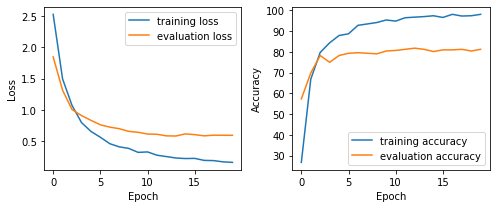

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

## Question 18

In [83]:
exp1.evaluate()

{'loss': 0.4794659003939318, 'accuracy': tensor(85.0544, device='cuda:0')}

In [84]:
exp2.evaluate()

{'loss': 0.5902257192394008, 'accuracy': tensor(81.2500, device='cuda:0')}

We can see that the accuracy of the ResNet18 architecture is 81.25 % and that of VGG is 85.05%. Since we have a limited dataset, using ResNet, which is a deeper network than VGG, may not be the best idea. Hence, we are getting lower accuracy for ResNet than VGG.